## Intro NLP - Disney

In deze notebook zullen we een *sentiment analysis* proberen uitvoeren op de Disneyland dataset. De dataset telt 42,000 reviews van 3 Disneyland parken (Parijs, Californië en Hong Kong), en de reviews werden achtergelaten door gebruikers van Trip Advisor.



### Stap 1 : data inladen

In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/DisneylandReviews.csv",encoding='latin-1')
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [6]:
df["Year_Month"] = pd.to_datetime(df["Year_Month"], errors='coerce')
df["Year"] = df["Year_Month"].dt.year
df["Month"] = df["Year_Month"].dt.month
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019.0,4.0
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019.0,5.0
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019.0,4.0
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019.0,4.0
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019.0,4.0


In [7]:
df.isnull().sum()/len(df)

Review_ID            0.000000
Rating               0.000000
Year_Month           0.061258
Reviewer_Location    0.000000
Review_Text          0.000000
Branch               0.000000
Year                 0.061258
Month                0.061258
dtype: float64

In [8]:
df.dropna(inplace=True)
df["Review_ID"].value_counts()

121570980    2
121615246    2
121586148    2
121580686    2
121578357    2
            ..
444105514    1
444045161    1
444044561    1
443909273    1
91827418     1
Name: Review_ID, Length: 40023, dtype: int64

In [9]:
df.drop_duplicates(subset="Review_ID",inplace=True, keep="first")
df.shape

(40023, 8)

In [10]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40023 entries, 0 to 42117
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Review_ID          40023 non-null  int64         
 1   Rating             40023 non-null  int64         
 2   Year_Month         40023 non-null  datetime64[ns]
 3   Reviewer_Location  40023 non-null  object        
 4   Review_Text        40023 non-null  object        
 5   Branch             40023 non-null  object        
 6   Year               40023 non-null  float64       
 7   Month              40023 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 2.7+ MB


### Stap 2 : text preprocessing : standardizatie, stop-words, stemming, vectorizatie

In [11]:
#Adding Sentiment Positive, Neutral & Negative

rating_count = df.Rating.value_counts()
rating_count

5    21899
4    10079
3     4778
2     1929
1     1338
Name: Rating, dtype: int64

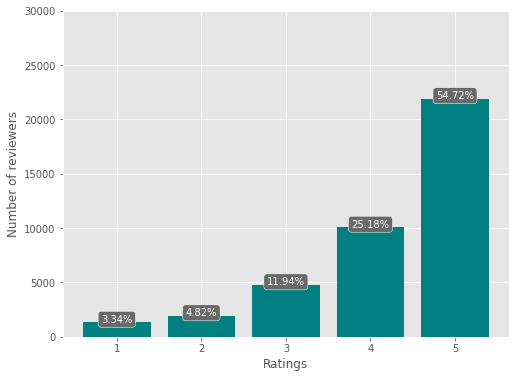

In [12]:
import matplotlib.pyplot as plt 
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 6))
    plt.bar(rating_count.index, rating_count.values, color='teal')
    for r, val in zip(rating_count.index, rating_count.values):
        plt.text(r, val, 
                 str(round(val/sum(rating_count.values)*100, 2))+'%', 
                 ha='center', color='white', 
                 bbox=dict(facecolor='dimgrey', edgecolor='white', boxstyle="round"))
    plt.xlabel('Ratings')
    plt.ylabel('Number of reviewers')
    plt.yticks(np.arange(0, 30001, 5000))

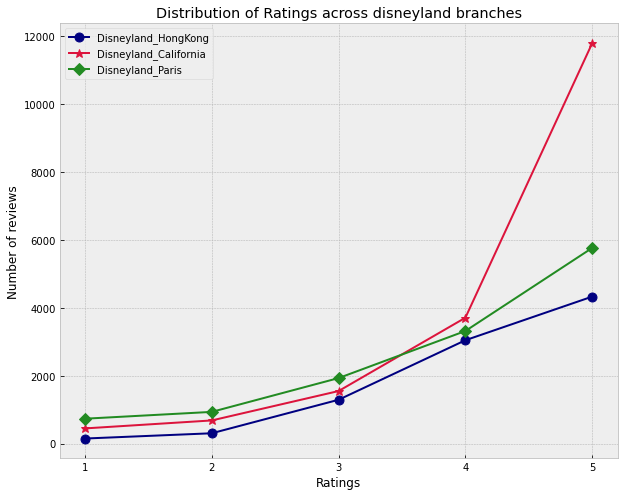

In [10]:
markers = ['o', '*', 'D']
branch_col = ['navy', 'crimson', 'forestgreen']
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 8))
    for branch, m, col in zip(df.Branch.unique(), markers, branch_col):
        counts = df[df.Branch == branch]['Rating'].value_counts()
        x = counts.index
        y = counts.values
        plt.plot(x, y, marker=m, markersize=9, color=col, label=branch)
        plt.xticks(np.arange(1, 6))
        plt.xlabel('Ratings')
        plt.ylabel('Number of reviews')
    plt.title('Distribution of Ratings across disneyland branches')
    plt.legend()
    plt.show()

In [12]:
pos = [5]
neg = [1, 2]
neu = [3, 4]

def sentiment(rating):
    if rating in pos:
        return 2
    elif rating in neg:
        return 0
    else:
        return 1  
df['Sentiment'] = df['Rating'].apply(sentiment)
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,Sentiment
0,670772142,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019.0,4.0,1
1,670682799,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019.0,5.0,1
2,670623270,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019.0,4.0,1
3,670607911,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019.0,4.0,1
4,670607296,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019.0,4.0,1


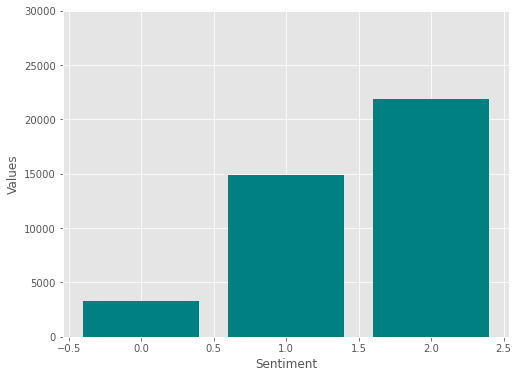

In [13]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(8, 6))
    plt.bar(df.Sentiment.value_counts().index, df.Sentiment.value_counts().tolist(), color='teal')
    plt.xlabel('Sentiment')
    plt.ylabel('Values')
    plt.yticks(np.arange(0, 30001, 5000))

## Text Processing Pipeline

1. Tokenization
2. Punctuation removal
3. Stopword Removal
4. Lower casing // negation handling
5. Stemming
6. Vectorization

### Manier 1 ML 
- CountVectorizer, TFIDF, Bag-of-Words 
- NLTK & VADER (https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk & https://realpython.com/python-nltk-sentiment-analysis/)


### Manier 2 : Deep-learning : RNN with Keras

- Text classification with RNN: https://www.tensorflow.org/text/tutorials/text_classification_rnn
- RNN with Keras (https://www.tensorflow.org/text/tutorials/text_classification_rnn)